In [2]:
import numpy as np

# matplotlib notebook will allow us to use interactive plots, but remember to stop the interaction to move on
# to next cell. Or you can just use inline plots without interaction
%matplotlib inline

import matplotlib.pyplot as plt

Let's start with a simulated simple emission line spectrum, for example of some lines in an AGN or HII region. Let's neglect natural broadening, but we will include velocity broadening as part of the intrinsic line width. The velocity broadening function is represented by a Gaussian. First let's implement a Gaussian broadening function:

In [3]:
def gauss(x,mean=0,sig=1) :
    """ Return normalized Gaussian here"""
    return 1/sig/np.sqrt(2*np.pi)*np.exp(-(x-mean)**2/(2*sig**2))   # add code here

OK, let's set up our desired output wavelength grid. Let's simulate between 6500 and 6600 A, but we need to decide on a wavelength range and a wavelength spacing. Let's say we want to be able to simulate velocity widths down to 1 km/s. What $\Delta\lambda$ does that correspond to at the wavelength of H$\alpha$ (6562.8 A)?
<br>
<b> ANSWER HERE: $\Delta\lambda = 1/3.e5 * 6563 = 0.0218$ A</b>
<br>


We want our spacing in wavelength to be $<=$ half of this number

In [4]:
# set up our output wavelengths for our underlying intrinsic spectrum
lambdastart=6500
lambdaend=6600
dlambda=0.01     # set appropriate dlambda (=A/pixel), you can round to a simple number
waves=np.arange(lambdastart,lambdaend,dlambda)
spec=np.zeros(waves.shape)


OK, let's write a function to make a simulated line, given an input wavelength, velocity width, and amplitude.

In [5]:
import copy
def mkline(waves,wline,vel_width,amp) :
    """ routine to add line flux to input spec array, given 
        wave:  wavelengths corresponding to spectral array pixels
        spec: input spectral array to add to
        wline: wavelength of the line to add
        vel_width: velocity width (km/s) of line to add
        amp: amplitude of line
        """
    out=np.zeros(waves.shape)
    dl=vel_width/3.e5*wline   # what delta lambda (FWHM) does the velocity width correspond to?
    sigma=dl/2.354            # what gaussian sigma does this correspond to?
    # we will add in the contribution of the line to every output pixel, although in practice this is
    # very wasteful, since the line is only going to contribute out to a few FWHM!
    out += amp*gauss(waves,mean=wline,sig=sigma)   # add in appropriate flux
    return out



OK, play around with making spectra with different wavelengths, widths, and amplitudes, to make sure it is working, but set it to an H$\alpha$ line width of 1 km/s when you are finished playing!

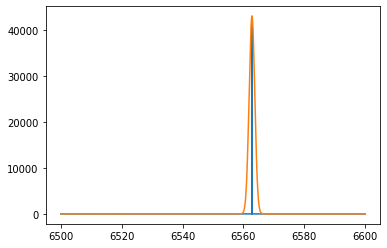

In [6]:
wave=6562.8  # wavelength of line to add
width=1      # velocity width in km/s
amp=1000     # amplitude of line in some arbitrary units at this point
spec=mkline(waves,wave,width,amp)   # add in the line here. 
plt.plot(waves,spec)

wave=6562.8
width=100
amp=100000

plt.plot(waves,mkline(waves,wave,width,amp))

OK, now we want to add the effect of instrumental resolution, which we will also represent by a constant Gaussian, with width input by the spectral resolution $R = {\lambda \over \Delta\lambda}$, where $\Delta\lambda$ is the FWHM of the instrumental resolution. Let's assume we have a spectrograph that gives a constant dispersion (fixed wavelength spacing between pixels), which strictly means a (slightly) variable resolution, so we'll assume the resolution $R$ refers to the center of the wavelength range. First let's created the smoothing kernel.

In [7]:
def get_kernel(waves,R=1000) :
    ''' Create a Gaussian smoothing kernel for a given input wavelength array and a resolution R
    '''
    wcen = waves[int(len(waves)/2)]     # wavelength center
    dl=wcen/R                           # set correspoding delta lambda corresponding to R at middle of range
    dlambda=waves[1]-waves[0]           # making assumption that our array is spaced by constant in wavelength!
    dl_pixels = dl / dlambda            # we want kernel in pixel space, so convert to delta lambda in pixels
    sig_pixels = int(dl_pixels / 2.354) # convert to Gaussian sigma, make it be an integer number of pixels
    print('Kernel Delta lambda:',dl)
    print('Kernel sigma in pixels: ',sig_pixels)
    x=np.arange(-5*sig_pixels,5*sig_pixels+1)  # set kernel to go from -5 sigma to 5 sigma, with an odd number of pixels
    kernel=gauss(x,sig=sig_pixels)      # populate kernel
    return kernel


A typical low/medium dispersion spectrograph (like DIS) might have R between 1000 and 3000. Let's make a kernel and check that it gives what you expect.

Kernel Delta lambda: 2.1833333333336973
Kernel sigma in pixels:  92
Kernel Delta lambda: 6.550000000001091
Kernel sigma in pixels:  278


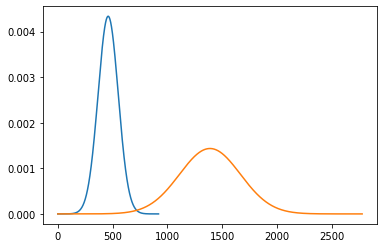

In [8]:
kernel=get_kernel(waves,R=3000)
plt.plot(kernel)
R=1000
kernel=get_kernel(waves,R=R)
plt.plot(kernel)

Explain whether what you see is what you expect, and why:<br>
<b> ANSWER HERE: </b> Higher resolution kernel is a narrower function than lower resolution. As a narrower function, we don't need to extend it to as many pixels as the lower resolution one.

Let's first write the convolution code ourselves. Recall, convolution takes the contribution of each input pixel, smears it, and spreads its contribution over a number of output pixels:<br>
$s(x)*k(x) = \int s(x') k(x-x') dx'$<br>
for a discretely sampled function, like we have, the integral becomes a sum:<br>
$s(x)*k(x) = \sum s(x') k(x-x')$ <br>
We have to loop over each output pixel and consider contributions from all input pixels which are within the smoothing kernel. Of course, in this case, it's pretty stupid, since almost the whole spectrum is zeros, but we mights use this routine below in a different case, and this is a good case to check that the routine gives what you expect! (what do you expect?)

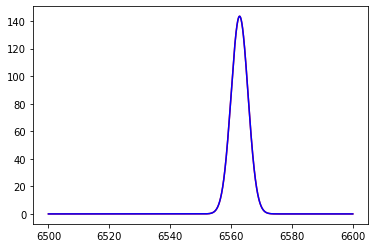

In [10]:
def my_convolve(spec,kernel,slow=True) :
    """ smooth input spectrum with input kernel
    """
    smoothed=np.zeros(len(spec))               # prepare output array
    kernel_width = int(round(len(kernel) / 2)) # determine kernel width

    # loop over every element of output array 
    for i in range(kernel_width,len(smoothed)-kernel_width) :   
        # loop over all contributing members of input array.
        # Note that doing this with a for loop is very inefficient! but it is explicit
        if slow :
            for j in range(i-kernel_width,i+kernel_width+1) :    
                # be careful here about the array indexing: the first pixel should be multiplied by the last
                # pixel in the kernel array, and the last pixel by the first. Remember that the first pixel
                # in an array is indexed 0
                smoothed[i] += spec[j]*kernel[i-j+kernel_width]
        else :
            # you can do this much faster using array multiplication !!
            smoothed[i] = np.sum(spec[i-kernel_width:i+kernel_width+1]*kernel[::-1])
    return smoothed

smoothed=my_convolve(spec,kernel,slow=False)
plt.plot(waves,smoothed,color='r')
plt.plot(waves,my_convolve(spec,kernel,slow=False),color='b')

Is it what you expected?  
<B> ANSWER HERE: </B> Yes the smoothed function should be gaussian with width equal to the quadrature sum of the width of the input line and width of the smoothing kernel.

OK now let's do the same thing with [numpy.convolve](https://docs.scipy.org/doc/numpy/reference/generated/numpy.convolve.html) routine, and compare the two results. If you want, play with the mode keyword, which can take values: 'same', 'full', 'valid'. What do these return in terms of the lengths of the arrays?  Do you understand why?

npix in input spectrum:  10000
npix convolved spectrum:  10000


(6550, 6580)

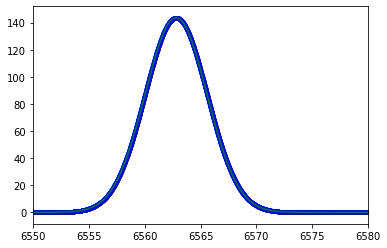

In [11]:
convolved=np.convolve(spec,kernel,mode='same')   #convolve spectrum with kernel
print('npix in input spectrum: ',len(spec))
print('npix convolved spectrum: ',len(convolved))
plt.plot(waves,smoothed,color='g')
plt.scatter(waves,convolved,color='b',s=10)
plt.xlim(6550,6580)

At this point, it's clear that we are very heavily oversampled: many more points than would be sampled by a spectrograph with our resolution. What is a reasonable sampling given our resolution R=1000, i.e. how many of our input pixels corresponds to an output pixel that samples our resolution at greater than the critical sampling, where we can take critical sampling as half the FWHM?

R:  1000
Desired wavelength spacing:  2.1833333333336973
Derived pixel sampling:  218


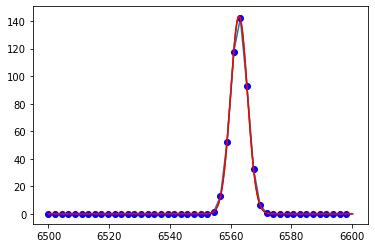

In [12]:
#lets say we want 3 sample per FWHM
samples=3
wcen = waves[int(len(waves)/2)]     # wavelength center
dl_desired = wcen/R/samples         # what is the corresponding wavelength spacing

# how many pixels is this in the original wavelength array?
nskip = int(dl_desired / (waves[1]-waves[0]))

# sample by taking every nskip pixels, in both wavelength and spectrum array
print('R: ',R)
print('Desired wavelength spacing: ',dl_desired)
print('Derived pixel sampling: ',nskip)

# arbitrary starting point if you want to play with recovering signal
start=0
out=convolved[start::nskip]
waves_out=waves[start::nskip]
#underlying function
plt.plot(waves,convolved,color='g')
plt.plot(waves_out,out)
plt.plot(waves_out,out,'bo')

# can you recover signal using scipy.signal.resample? even with arbitrary starting point?
import scipy.signal
a,b=scipy.signal.resample(out,len(out)*nskip,t=waves_out)
plt.plot(b,a,color='r')


OK, now let's add some continuum level. For now, let's set this continuum level by specifying the S/N in the continuum

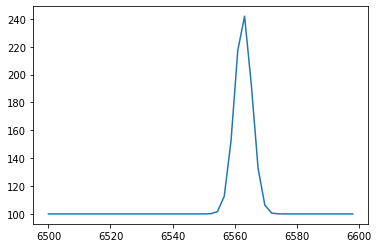

In [13]:
sn=10
cont=sn**2       # what continuum level corresponds to the chosen S/N?
sum=out+cont
plt.plot(waves_out,sum)

OK, now we will add in Poisson noise using [numpy.random.poisson()](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.random.poisson.html). You can run this a number of times to see what sort of
variation comes up, especially at lower S/N!

(6550, 6580)

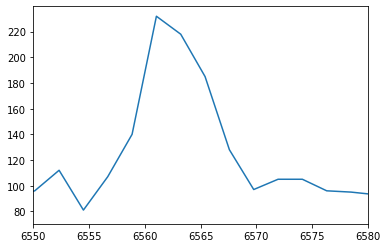

In [14]:
spec_poiss = np.random.poisson(sum)   # how do we add in Poisson noise
plt.plot(waves_out,spec_poiss)
plt.xlim(6550,6580)

Finally, let's add in some readout noise using [numpy.random.normal](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.random.normal.html)

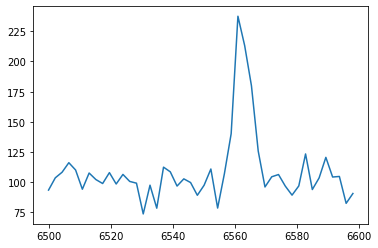

In [15]:
rn=5
out = spec_poiss + np.random.normal(0,rn,size=len(spec_poiss))
plt.plot(waves_out,out)

Let's put all of our steps together into one routine, to go from an underlying spectrum, to an "observed" one, in one function call. Here we're going to separate out a sky level to add, and then a S/N to scale the (median value of the) spectrum to, to allow us to use it below with a stellar spectrum


Kernel Delta lambda: 6.550000000001091
Kernel sigma in pixels:  278


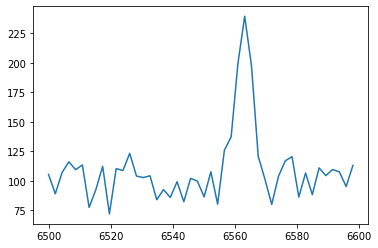

In [16]:
def specsim(waves,spec,R=3000,samples=3,sky=100,sn=10,rn=3) :
    """ given input wavelength and spectrum, create 'observed' spectrum
        waves: input wavelength array
        spec : input spectrum
        R : desired resolution
        samples : desired sampling (samples pixels per resolution element)
        sky : sky level to add (in same units as spec)
        sn : scale levels for a mean S/N
        rn : readout noise
    """
    kernel=get_kernel(waves,R=R)     # get the smoothing kernel
    smoothed=np.convolve(spec,kernel,mode='same')  # convolve
    wcen = waves[int(len(waves)/2)]     # wavelength center
    dl_desired = wcen/R/samples         # what is the corresponding wavelength spacing
    nskip = int(dl_desired / (waves[1]-waves[0]))   #determine sampling of input array
    out=smoothed[::nskip] + sky       # sample and add sky
    level=sn**2                       # desired level, given S/N
    out*= level/np.median(out)        # scale to desired level
    final=np.random.poisson(out)+np.random.normal(0,rn,size=len(out))   # add Poisson and readout noise
    return waves[::nskip],final

waves_out,out=specsim(waves,spec,rn=5,samples=3,R=1000)
plt.plot(waves_out,out)
    
    

OK, now use your routines to simulate 3 lines: Halpha and the [NII] lines at 6548.3 and 6583.41. Note that the latter two come in a fixed amplitude ratio of [1:3] from atomic physics. Note that in an HII region, line widths are of order 10 km/s (I think?). Line ratios, e.g. between H lines and [NII] lines depend on conditions, like metallicity, but [NII]6583/Ha is generally<1 (see [BPT](https://ned.ipac.caltech.edu/level5/Glossary/Essay_bpt.html) diagrams!). In an AGN, the broad permitted lines can have velocity widths of 1000 km/s, while narrow forbidden lines have widths around 100 km/s. [NII]6583/Ha is generally>~1 (see [BPT](https://ned.ipac.caltech.edu/level5/Glossary/Essay_bpt.html) diagrams!).

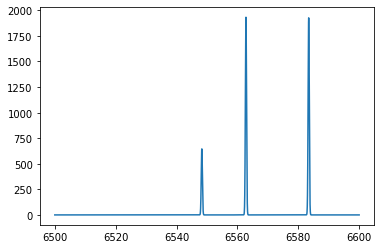

In [17]:
lines=[6548.3,6562.8,6583.41]   # [NII]6548, Ha6563, [NII]6583
amps=[300,900,900]            # relative amplitudes here
velwidths=[20,20,20]            # velocity widths
spec=np.zeros(len(waves))
for line,amp,vel in zip(lines,amps,velwidths) :
    spec+=mkline(waves,line,vel,amp)    # add in each line
      
plt.plot(waves,spec)

OK, play around with simulations at different, R, S/N, and readout noise

Kernel Delta lambda: 6.550000000001091
Kernel sigma in pixels:  278
Kernel Delta lambda: 13.100000000002183
Kernel sigma in pixels:  556
Kernel Delta lambda: 2.1833333333336973
Kernel sigma in pixels:  92


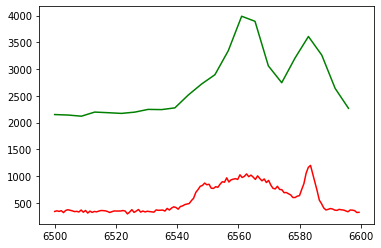

In [34]:
lines=[6548.3,6562.8,6583.41]   # [NII]6548, Ha6563, [NII]6583
amps=[300,900,900]            # relative amplitudes here
velwidths=[100,1000,100]            # velocity widths
spec=np.zeros(len(waves))
for line,amp,vel in zip(lines,amps,velwidths) :
    spec+=mkline(waves,line,vel,amp)    # add in each line

# simulate the observed spectrum
waves_out,out=specsim(waves,spec,R=1000,sn=50,rn=3)
#plt.plot(waves_out,out,color='g')
#waves_out,out=specsim(waves,spec,R=3000,sn=50,rn=3)
#plt.plot(waves_out,out,color='b')
#...


<B> Stellar spectrum simulation</B><br>
OK, now let's play around with a simulated stellar spectrum. Start from a synthetic spectrum from [star.txt](http://astronomy.nmsu.edu/holtz/a630/notebooks/star.txt), which you will need to download into the directory that you are running the notebook from, or else change the path below. Note that this simulated spectrum is at fixed spacing of 0.3 A, giving a resolution of R=10000 at the shortest wavelength end; our routines can only be used to generate spectra at lower resolution than the input spectrum.

 WAVE     FLUX  
------ ---------
3000.2   71530.0
3000.5   73160.0
3000.8   75550.0
3001.1   78590.0
3001.4   82230.0
3001.7   86370.0
3002.0   91400.0
3002.3   97980.0
3002.6  107100.0
3002.9  120100.0
   ...       ...
6993.8 3710000.0
6994.1 3710000.0
6994.4 3709000.0
6994.7 3709000.0
6995.0 3709000.0
6995.3 3709000.0
6995.6 3709000.0
6995.9 3708000.0
6996.2 3708000.0
6996.5 3708000.0
6996.8 3708000.0
Length = 13323 rows


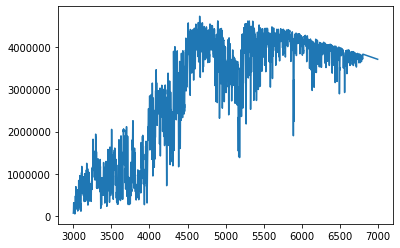

In [70]:
from astropy.io import ascii
star=ascii.read('star.txt')   # read it in
print(star)
plt.plot(star['WAVE'],star['FLUX'])   # plot it

OK, now let's use our simulation routine. Now you can see why we want a routine that scales the input spectrum to produce a desired S/N. Play around with different S/N, R, and sky

Kernel Delta lambda: 0.9997
Kernel sigma in pixels:  1


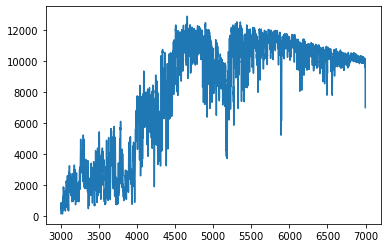

In [71]:
waves_out,out=specsim(star['WAVE'],star['FLUX'],sky=0,sn=100,R=5000)
plt.plot(waves_out,out)

OK, how about generating the stellar spectrum with a radial velocity? To do this, let's keep the same wavelength grid, but interpolate the flux to be appropriate for an object with a radial velocity. Here we will use a cubic spline interpolator, under the assumption that the synthetic spectrum is well sampled (which it may or may not be!)

(6200, 6250)

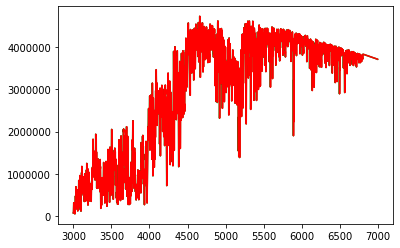

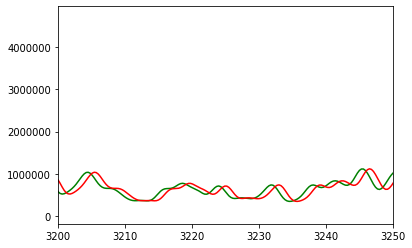

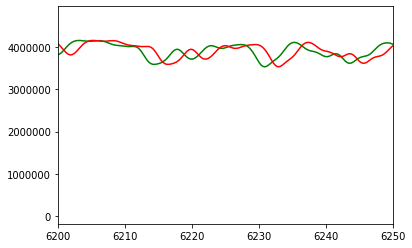

In [72]:
from scipy.interpolate import interp1d

def rvshift(wave,spec,rv=100) :
    """ Given input wavelength and spectral arrays, return RV-shifted spectrum on original wavelength grid"""
    interp=interp1d(wave,spec,fill_value='extrapolate',kind='cubic')   # get an cubic spline interpolator
    wold = wave-rv*wave/3.e5       # what is the wavelength in the old array for the input RV?
    new=interp(wold)
    return new

# get the shifted spectrum
new=rvshift(star['WAVE'],star['FLUX'],rv=100)

# plot unshifted and shifted spectrum to verify your result
plt.plot(star['WAVE'],star['FLUX'],color='g')
plt.plot(star['WAVE'],new,color='r')

plt.figure()
plt.plot(star['WAVE'],star['FLUX'],color='g')
plt.plot(star['WAVE'],new,color='r')
plt.xlim(3200,3250)

plt.figure()
plt.plot(star['WAVE'],star['FLUX'],color='g')
plt.plot(star['WAVE'],new,color='r')
plt.xlim(6200,6250)




Is the shift constant with wavelength? If not, how does it vary:<br>
<B> ANSWER HERE: </B> No, it varies linearly with wavelength

Now we get observed spectrum: simulate a high S/N spectrum of a template, then another simulation of the shifted RV-shifted spectrum, perhaps at lower S/N

Kernel Delta lambda: 4.9985
Kernel sigma in pixels:  7
Kernel Delta lambda: 4.9985
Kernel sigma in pixels:  7


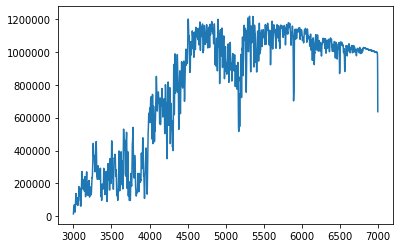

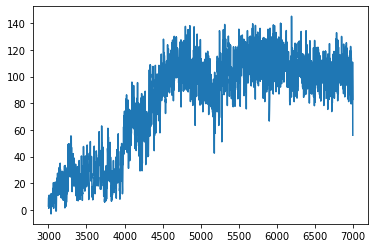

In [81]:
R=1000        # choose a resolution

# first get a template at desired resolution
sky=0
sn=1000       # choose a S/N, can be very high for template, i.e. just resample model at desired resolution
waves_out,template=specsim(star['WAVE'],star['FLUX'],sky=sky,sn=sn,R=R)
plt.plot(waves_out,template)

# now simulate object
rv=375
sky=0
sn=10
obj=rvshift(star['WAVE'],star['FLUX'],rv=rv)
waves_out,obj=specsim(star['WAVE'],obj,sky=sky,sn=sn,R=R)
plt.figure()
plt.plot(waves_out,obj)


Are the template and object spectra at the expected levels? Does the noise seem reasonable? <br>
<B> ANSWER HERE: </B> Yes, for S/N=50, expect median level to be 2500. A bit hard to see the noise because the absorption line structure is deeper than 2%, which is the noise associated with S/N=50

A common technique to derive the radial velocity is to cross correlate the observed spectrum with some template that is chosen to try to match the spectral energy distribution of the target; if that is unknown, then one might cross-correlate with a bunch of different templates, and choose the one that produces the highest cross-correlation (most similar spectrum). The radial velocity is then derived from the location of the cross-correlation peak, which says how much the template spectrum needs to be shifted to match the observed spectrum.<br>

However, we have to be a little careful with a number of things. Since the shift in wavelength for a given velocity is proportional to wavelength, there isn't a single shift that will apply across the whole wavelength range! But,
we can rewrite ${\Delta\lambda\over \lambda} = {v\over c}$ as $\Delta(\ln\lambda) = {v\over c}$, i.e. a velocity shift is a constant shift in $\ln\lambda$ <br>

So we need to resample the spectra into constant $\ln\lambda$ sampling. For a well sampled spectrum, the correct way to do this is probably sinc interpolation (remember the sampling theorem?), but we will use built-in cubic spline interpolation for a quick implementation here:



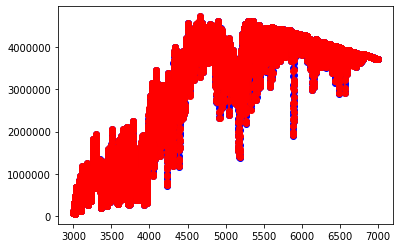

In [82]:
def log_interp(w,f) :
    """ Routine to intepolate input spectrum to log(lambda) scale
         with spacing chosen from the dlog_lambda of the first wavelenght
    """
    interp=interp1d(w,f,fill_value='extrapolate',kind='cubic')   # get an cubic spline interpolator
    dl=w[1]-w[0]
    dlog_lambda = dl/w[0]     # let's just use the spacing in ln(lambda) corresponding to the dispersion at the first pixel 
    # create a new wavelength array covering the same range, but in ln(lambda) spacing
    loglambda = np.arange(np.log(w[0]),np.log(w[-1]),dlog_lambda)
    flux_loglambda = interp(np.exp(loglambda))
    return loglambda, flux_loglambda

# let's interpolate our input spectrum to a log(lambda) scale
loglambda,flux_loglambda = log_interp(star['WAVE'],star['FLUX'])

# check the interpolation by plotting original and interpolated spectrum
plt.plot(star['WAVE'],star['FLUX'],color='b')
plt.plot(star['WAVE'],star['FLUX'],'bo')
plt.plot(np.exp(loglambda),flux_loglambda,color='r')
plt.plot(np.exp(loglambda),flux_loglambda,'ro')

OK, let's put our template and object on a log lambda scale, and check for shift as a function of wavelength

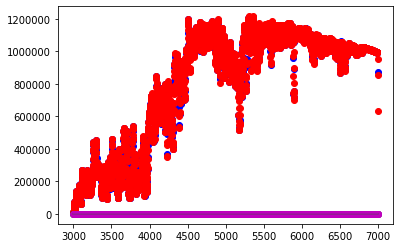

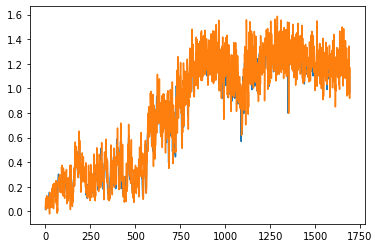

In [83]:
# interpolate both template and object to loglambda scale
w=waves_out
loglambda,template_loglambda = log_interp(w,template)
loglambda,obj_loglambda = log_interp(w,obj)

# check the interpolation by plotting original and interpolated spectrum
plt.plot(np.exp(loglambda),template_loglambda,'bo')
plt.plot(w,template,'ro')

plt.plot(np.exp(loglambda),obj_loglambda,'go')
plt.plot(w,obj,'mo')
plt.plot(np.exp(loglambda),obj_loglambda,'g')
plt.plot(w,obj,'m')

#plot in pixel space to look at shifts if desired
plt.figure()
plt.plot(template_loglambda/np.median(template_loglambda))
plt.plot(obj_loglambda/np.median(obj_loglambda))



Another thing we need to be careful of in cross correlation is the continuum level. If the signal has a mean value greater than 0, the cross correlation will be "diluted" by the continuum contribution, and edge effects will be very significant; imagine that the signal drops to zero off the edges, which will lead to a big change in cross-correlation as the edges slide relative to each other. As a result, the mean level is typically removed before cross-correlation. Here, the continuum level is clearly a function of wavelength. We'll remove an approximate continuum by subtracting a "median-filtered" version of the spectrum: imagine running a window across the spectrum and taking the median value in the window around each pixel. We will use [scipy.signal.medfilt](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.medfilt.html) to do this, although the principle is simple.<br>

We will build this continuum subtraction into a short cross-correlation function, using [numpy.correlate](https://docs.scipy.org/doc/numpy/reference/generated/numpy.correlate.html) to do the actual cross-correlation of the continuum-removed spectra. numpy.correlate() will cross-correlate two spectra across a large range of shifts, depending on the mode keyword, but even the smallest of these is likely overkill for the RV problem, if we expect that the shift is small (pixels or tens of pixels). Here, we use it with the mode='same' option, which will produce a cross-correlation function of the same size as the first array, which means it is computing shifts from the second array being shifted one half of its length to the left up through one half of its length to the right: zero lag will be in the middle of cross-correlation array. 

It would be very straightforward, and possibly simpler to understand, to write your own (perhaps one-line!) cross correlation routine that returned the cross-correlation function as a function of shift (lag).


(-5, 5)

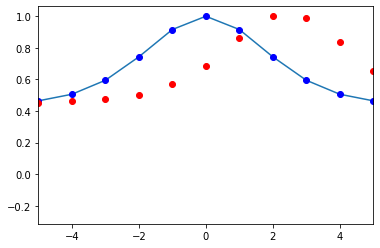

In [84]:
import scipy.signal
def xcorr(a,b) :
    """ Cross correlate two spectra, but remove the median levels first
    """
    xc=np.correlate(a-scipy.signal.medfilt(a,401),b-scipy.signal.medfilt(b,401),mode='same')
    # with mode='same', the zero shift cross-correlation is in the middle of the output array
    if len(xc)%2 == 0 :
        lag=np.arange(len(xc))-len(xc)/2
    else :
        lag=np.arange(len(xc))-(len(xc)-1)/2

    return lag, xc 

# cross correlate template with itself as a check
lag,xc=xcorr(template_loglambda,template_loglambda)

# cross correlate template with object
lag,xc2=xcorr(obj_loglambda,template_loglambda)

# plot cross correlation as a function of lag
plt.plot(lag,xc/xc.max())
plt.plot(lag,xc/xc.max(),'bo')
plt.plot(lag,xc2/xc2.max(),'ro')
plt.xlim(-5,5)



We have to interpret these cross-correlation functions! Note that while it seems that you can only measure the radial velocity corresponding the sampling of the spectrum (in $\ln\lambda$), you can actually do a little bit better by interpolating around the peak to get a fractional pixel shift: often, people fit a quadratic function to the peak.


In [85]:
dlog_lambda=(loglambda[1]-loglambda[0])
print(dlog_lambda,dlog_lambda*3.e5)
# RV corresponding to peak pixel of cross-correlation
imax=xc2.argmax()
print(lag[imax],lag[imax]*dlog_lambda*3.e5)


0.0004999666688885185 149.99000066655555
2.0 299.9800013331111


If you are so inclined, write a routine to fit the peak, and turn the fractional shift into a derived radial velocity. Run this for spectra at different RVs and different S/N, and see how well you can do! I've collected all of the pieces in the following cell for generating the spectra and the cross-corrleation


2.3668823285068066
RV:  355.0086820303945


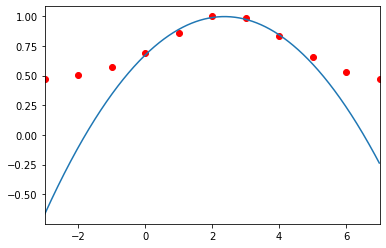

In [90]:
def getlag(lag,xc) :
    """ Get fraction lag from fit to peak of cross correlation
    """
    imax=xc.argmax()
    fit=np.polyfit(lag[imax-2:imax+3],xc[imax-2:imax+3]/xc.max(),2)
    plt.plot(lag,xc/xc .max(),'ro')
    xfit=np.arange(lag[imax]-5,lag[imax]+5,0.01)
    plt.plot(xfit,fit[0]*xfit**2+fit[1]*xfit+fit[2])
    plt.xlim(lag[imax]-5,lag[imax]+5)
    peak=-fit[1]/(2*fit[0])
    print(peak)
    return peak

peak=getlag(lag,xc2)
print('RV: ',peak*dlog_lambda*3.e5)

Kernel Delta lambda: 4.9985
Kernel sigma in pixels:  7
Kernel Delta lambda: 4.9985
Kernel sigma in pixels:  7
2.3668823285068066
RV:  355.0086820303945


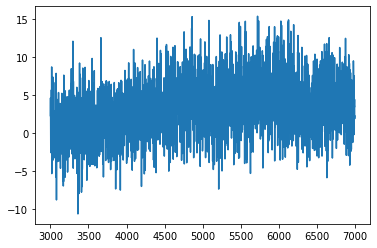

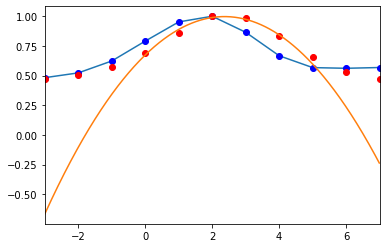

In [91]:
R=1000        # choose a resolution

# first get a template at desired resolution
waves_out,template=specsim(star['WAVE'],star['FLUX'],sky=0,sn=1000,R=R)

# now simulate object
rv=300
sky=0
sn=2
obj=rvshift(star['WAVE'],star['FLUX'],rv=rv)
waves_out,obj=specsim(star['WAVE'],obj,sky=sky,sn=sn,R=R)
plt.plot(waves_out,obj)

# interpolate both template and object to loglambda scale
loglambda,template_loglambda = log_interp(w,template)
loglambda,obj_loglambda = log_interp(w,obj)

# cross correlate template with object
lag,xc=xcorr(obj_loglambda,template_loglambda)

# plot cross correlation as a function of lag
plt.figure()
plt.plot(lag,xc/xc.max())
plt.plot(lag,xc/xc.max(),'bo')
plt.xlim(-5,5)
peak=getlag(lag,xc2)
print('RV: ',peak*dlog_lambda*3.e5)

# add code here to fit peak, plot fit, determine peak of fit, and corresponding RV


Run this cell multiple times for different RVs, resolutions, S/N. What can you say about the ability to measure RVs as a function of these values? <br>
<b>ANSWER HERE: </b> Find you can get pretty good RVs down to quite low S/N ~ 2! As resolution gets worse, accuracy of RVs gets worse

Note, however, that there are lots of potential issues with using cross-correlation to get radial velocities!  This is not necessarily the optimal method!
<br>
For one, there is the issue of bad or missing data in the observed (or template spectrum). Spurious signals can really mess up the cross-correlation! So need to be careful about than
<br>
Second, the procedure requires resampling spectra to a logarithmic wavelength scale. Beware of resampling! Apart from the possibility of adding interpolation noise if you don't choose a good sampler and/or if you are not critically sampled, there is the issue that we are generally interpolating in a spectrum that has noise in it. Interpolating in a noisy spectrum leads to correlated uncertainties in the interpolated spectrum: a pixel that happens to be high in the observed noisy spectrum will lead to a few pixels being high in the interpolated spectrum. This can cause systematic uncertainties in results using the interpolated spectrum!
<br>
Better methods might use some type of "forward modeling", where one puts (noiseless) models into observed space, rahter than trying to put noisy data into "model space".

<b> Stellar imaging simulation </b>
OK, changing gear here, let's see if we can simulate an image of a stellar field. Here we will just start with random spatial distribution of stars, but draw a luminosity distribution from a stellar luminosity function. To do that, we will use a stellar isochrone, which gives properties of stars (e.g., their luminosities and colors) as a function of stellar mass. Combined with an initial mass function, this gives us a stellar luminosity function: number of stars as a function of luminosity. Start by reading in an isochrones file for a population of solar metallicity stars at an age of 10 Gyr, [iso10.dat](http://astronomy.nmsu.edu/holtz/a630/notebooks/iso10.dat)

In [26]:
iso=ascii.read('iso10.dat')
print(iso)

  Z    logage   M_ini    M_act    logL  ...   H      K     int_IMF   stage
------ ------ ---------- ------ ------- ... ------ ------ ---------- -----
0.0152   10.0       0.09   0.09 -3.4229 ... 10.542 10.239 1.46765435     1
0.0152   10.0        0.1    0.1 -3.2404 ... 10.146  9.836 1.57040203     1
0.0152   10.0       0.12   0.12 -2.9755 ...  9.565  9.247 1.74782515     1
0.0152   10.0       0.14   0.14 -2.7918 ...   9.15  8.834 1.89584959     1
0.0152   10.0       0.16   0.16 -2.6501 ...  8.827  8.516  2.0211525     1
0.0152   10.0        0.2    0.2 -2.4305 ...   8.32   8.02 2.22178221     1
0.0152   10.0       0.25   0.25 -2.2171 ...  7.825  7.538 2.40809011     1
0.0152   10.0 0.30000001    0.3 -2.0509 ...   7.43  7.153 2.54750419     1
0.0152   10.0 0.34999999   0.35 -1.9049 ...  7.081  6.812  2.6555202     1
0.0152   10.0 0.40000001    0.4 -1.7604 ...  6.739  6.482  2.7413373     1
   ...    ...        ...    ...     ... ...    ...    ...        ...   ...
0.0152   10.0 1.03946924 

We want to draw from the isochrone according to the luminosity function, and we will do this using the transformation method. This isochrone comes with a convenient column, int_IMF, which is the integral of the IMF up to each mass (the file is sorted by initial stellar mass). There's some units in this, but let's convert it to a cumulative distribution function by forcing it to start at 0 and end at 1.

1.46765435 3.15118766


Text(0, 0.5, 'cumulative distribution function')

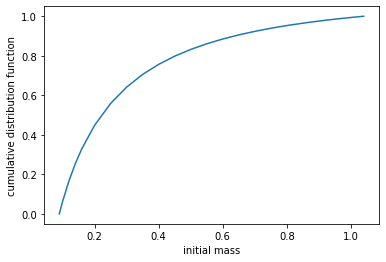

In [49]:
print(iso['int_IMF'][0],iso['int_IMF'][-1])

# create the cumulative distribution function
cdf=(iso['int_IMF']-iso['int_IMF'][0]) / (iso['int_IMF'][-1]-iso['int_IMF'][0])
niso=len(iso)
plt.plot(iso['M_ini'],cdf)
plt.xlabel('initial mass')
plt.ylabel('cumulative distribution function')


Does the mass range make sense? Why or why not?<br>
<B> ANSWER HERE: </B> Yes, because a standard IMF has a lot more low mass stars than high mass stars, and for an age of 10 Gyr, don't expect any stars with M greater than ~1 solar mass

We will do the transformation method numerically. Let's get an interpolating function that allows us to go from CDF to index number in the isochrone

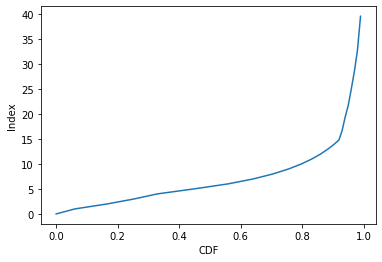

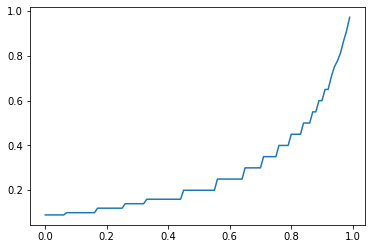

In [75]:
# get an interpolator for the inverse of the IMF. Here we will map back to the index number
interp=scipy.interpolate.interp1d(cdf,range(niso))
x=np.arange(0,1,0.01)
plt.figure()
plt.plot(x,interp(x))
plt.xlabel('CDF')
plt.ylabel('Index')


plt.figure()
plt.plot(x,iso['M_ini'][interp(x).astype(int)])


Are the corresponding initial masses what you expect? Why or why not? What is the plot of indices telling you about the number of points along different stages of the isochrone?
<b> ANSWER HERE: </b>: Yes. Most draws of CDF will give low mass stars (lower plot). Upper plot shows that most of the points in the isochrones are for the evolved stars, which makes sense because that's where things change the fastest.

OK, now we want to draw random samples, and get the luminosities and colors. Do this for different numbers of random draws. Do you get what you expect? Why or why not?<br>
<B> ANSWER HERE: </B> Yes, for few stars, only see the lower main sequence, need to simulate a lot of stars to see red giants!

(15, -3)

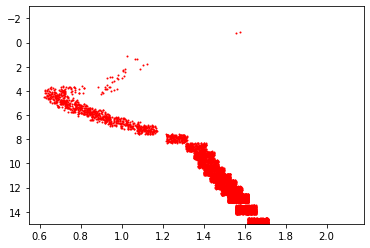

In [70]:
nstars=10000
vals=np.random.uniform(size=nstars)
# here we will just choose the nearest isochrone point (in principle, we could interpolate)
inds=np.round(interp(vals)).astype(int)
plt.figure()
# I've added some random scatter to the points to try to demonstrate the relative numbers better
#  since we are not interpolating in the isochrones, but just choosing the nearest point
plt.scatter(iso['B'][inds]-iso['V'][inds]+np.random.uniform(-0.05,0.05,size=len(inds)),
         iso['V'][inds]+np.random.uniform(-0.35,0.35,size=len(inds)),color='r',s=1)
plt.ylim(15,-3)

OK now we want to simulate the image! Get some random positions for the randomly drawn stars

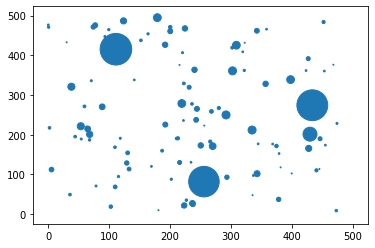

In [59]:
# get the isochrone index numbers for desired number of stars
nstars=1000
vals=np.random.uniform(size=nstars)
inds=np.round(interp(vals)).astype(int)

# get desired positions and assign x,y, and luminosity
npix=500
x=np.random.uniform(0,npix,size=nstars)
y=np.random.uniform(0,npix,size=nstars)
vlum=10.**(-0.4*iso['V'][inds])
# here, arbitrarily scaling so that brightest object has luminosity of 1000
vlum=vlum/vlum.max()*1000

# plot using point size scale with luminosity
plt.scatter(x,y,s=vlum.astype(int))

OK, now create a 2-d image npix by npix, create a gaussian routine for star profiles, and add the stars into the image with relative fluxes

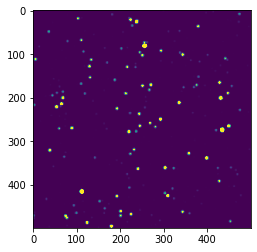

In [60]:
# Function to return values for a symmetric 2D normalized gaussian 
def gauss2d(r2,sig=1) :
    """ for input 2D array of distances**2, return Gaussian at those distances
    """
    # to save time, only compute gaussian at distances <=5*sigma
    gd=np.where(r2<25*sig)
    # output array at full size
    out=np.zeros(r2.shape)
    # populate output with gaussian
    out[gd[0],gd[1]]=1/(2*np.pi*sig)*np.exp(-r2[gd[0],gd[1]]/2/sig**2)
    return out

#create the image
image=np.zeros([npix,npix])

# numpy.mgrid is a convenient function for filling 2D arrays with x, y pixels values
ypix,xpix = np.mgrid[0:npix,0:npix]

# loop over all stars and populate image
fwhm=4
for col,row,lum in zip(x,y,vlum) :
    xdist=xpix-col
    ydist=ypix-row
    dist2=xdist**2+ydist**2
    image += lum*gauss2d(dist2,sig=fwhm/2.354)
plt.imshow(image,vmin=0,vmax=1)
    
    

Determine a flux scaling factor, and background, and add Poisson noise and readout noise


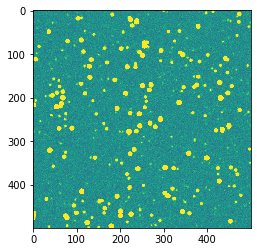

In [62]:
scale=10000      # multiplicative scale factor
background=100   # background level
rn=5             # readout noise
out = scale*image + background    # create noiseless scaled image plut background
out=np.random.poisson(out) + np.random.normal(0,rn,size=(npix,npix))   # add poisson noise and readout noise0

# display the image, selecting appropriate scale factor
plt.imshow(out,vmin=0,vmax=200)